In [53]:
pip install trimesh

In [54]:
import os
import random
import glob
import trimesh
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import scipy 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv3D, Dense ,Dropout, Flatten, Activation, MaxPooling3D, Input

from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



In [55]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    print("reading from cloud...")
    path = "/content/drive/MyDrive/data_70p_overhang/stls_opt/"
    path_vox = "/content/drive/MyDrive/data_70p_overhang/voxels/"
    
except:
    import pathlib
    print("reading from disk")
    path = str(pathlib.Path().resolve())+"/dataset/stls_opt/"
    path_vox = str(pathlib.Path().resolve())+"/dataset/voxels/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
reading from cloud...


In [56]:
mesh = trimesh.load(path+"63_8475_10313_17790_28845.stl")

In [57]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.05, 0.05, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points

def calculate_cost(filename):
  #params
  #time - parts usally need 15 minutes for preparation
  #1h - 10eur
  price_per_h = 2
  price_per_meter = 0.17#0.1133 #150 meters costs 17e 
  filament_diameter = 2.85 #mm
  filament_phi = np.power(filament_diameter/2,2)*np.pi #mm^2
  
  support_removal_multiplier= 2
  support_removal_multiplier_time = 1.5
  profit_margin = 0.1
  #larger parts need longer time + 5 minutes slice time. 
  
  #get data from filename
  data = filename.replace(".","_").split("_")
  data = [int(x) for x in data[:-1]]

  #calculate cost from filament lenght

  #calulate cost no support 
  cost_filament = ((data[2]/(filament_phi*1000)))*price_per_meter

  #calulcate cost of printing supports only 
  cost_supports = (abs(data[2]-data[4])/(filament_phi*1000))*price_per_meter
  cost_supports_removal = support_removal_multiplier*cost_supports

  #calulate timewise cost in hours
  print_time = data[1]
  print_time_supports = data[3]

  #convert to horus and include time for removing supports 
  print_time= (((print_time + 2*abs(print_time-print_time_supports))*support_removal_multiplier_time)/3600)
  print_time_cost = print_time * price_per_h

  #cena
  cost = (cost_filament+cost_supports+cost_supports_removal+print_time_cost)
  cost = (cost*profit_margin)+cost

  return cost

In [58]:
n_samples = 4096
n_aug_samples = 5
X = np.zeros([0,n_samples,3])

X_volume = np.zeros([0,1])
X_area = np.zeros([0,1])

y= np.zeros(0)

for filename in os.listdir(path):
    if filename.endswith(".stl"):
        print("appending", filename)
        mesh = trimesh.load(path+filename)
        points = mesh.sample(n_samples)
        
        for n in range(n_aug_samples):

            points = augment(points)
            X = np.append(X,points[np.newaxis,...],axis=0)

            cost = calculate_cost(filename)
            y = np.append(y,cost)

            mv = np.array(abs(mesh.volume))
            X_volume = np.append(X_volume,mv[np.newaxis,...])

            ma = np.array(abs(mesh.area))
            X_area = np.append(X_area,ma[np.newaxis,...])

X_area = X_area[...,np.newaxis]
X_volume = X_volume[...,np.newaxis]
X = X

appending 0_4642_6102_5531_7111.stl
appending 1_417_670_417_670.stl
appending 2_12292_15295_12292_15295.stl
appending 3_5996_8816_5996_8815.stl
appending 5_68210_116010_68210_116010.stl
appending 4_12043_12985_13969_15347.stl
appending 6_1483_2007_1775_2451.stl
appending 7_80399_111789_97309_121139.stl
appending 8_92217_167844_92549_168286.stl
appending 9_51285_85342_57860_89760.stl
appending 10_5421_7012_5765_7526.stl
appending 12_61494_92702_67554_99527.stl
appending 11_115891_198292_118752_200556.stl
appending 13_171_352_171_351.stl
appending 14_1717_2338_1717_2338.stl
appending 15_32561_52975_32990_53491.stl
appending 16_27552_38176_31634_41677.stl
appending 17_7383_11480_7541_11729.stl
appending 19_28215_40348_32459_44740.stl
appending 18_458_631_458_631.stl
appending 20_27655_40122_29843_42884.stl
appending 21_8153_8675_9475_9955.stl
appending 22_5251_6421_7262_7950.stl
appending 24_6790_8278_6965_8426.stl
appending 23_18353_28331_25958_39731.stl
appending 25_130346_244219_130346

In [59]:
n_samples = X.shape[0]
train_ind, test_ind  = train_test_split(range(n_samples), test_size=0.2, random_state=36)

X_train = X[train_ind]
X_train_volume = X_volume[train_ind]
X_train_area = X_area[train_ind]
y_train = y[train_ind]

X_test = X[test_ind]
X_test_volume = X_volume[test_ind]
X_test_area = X_area[test_ind]
y_test = y[test_ind]

print("train",X_train.shape,X_train_volume.shape,X_train_area.shape)
print("test",X_test.shape,X_test_volume.shape,X_test_area.shape)

train (784, 4096, 3) (784, 1) (784, 1)
test (196, 4096, 3) (196, 1) (196, 1)


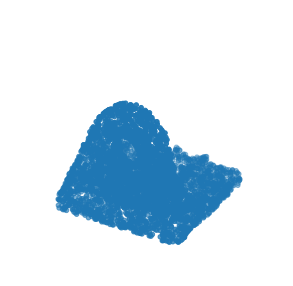

In [60]:
points = mesh.sample(5000)
#points = augment(points)
for points in X_train:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111,projection="3d")
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    ax.set_axis_off()
    plt.show()
    break

In [61]:
input1 = keras.Input(shape=(X_train.shape[1:]))
input2 = keras.Input(shape=(X_train_volume.shape[1:]))
input3 = keras.Input(shape=(X_train_area.shape[1:]))


x = tnet(input1, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
#x = layers.Dropout(0.3)(x)

x = Activation('relu')(x)


x = Flatten()(x)

x = layers.Concatenate()([x,input2])
x = layers.Concatenate()([x,input3])


dense = Dense(2000, activation = 'relu')(x)
dense = Dense(300, activation = 'relu')(dense)
dense = Dense(150, activation = 'relu')(dense)
dense = Dense(20, activation = 'relu')(dense)
dense = Dense(16, activation = 'relu')(dense)
    # final layer with 10 neurons to classify the instances
output = Dense(1, activation = 'linear')(dense)
    
#outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs=[input1,input2,input3], outputs=output, name="jjnet")
#model.summary()

In [52]:
def augment(points):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points

#fuctions to build models 
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

#function to create T-net layers
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def min_max(img):

    img =(img -(np.min(img)))
    img = img/np.max(img)
    return img

In [62]:
model.compile(
    loss="MSE",
    optimizer=keras.optimizers.Adam(learning_rate=0.000001),
    metrics=["MAPE"],
)

model.fit([X_train,np.log(X_train_volume), np.log(X_train_area)], np.log(y_train),validation_split = 0.2, batch_size = 8, epochs = 100, verbose = 1)


Epoch 1/100
79/79 [==============================] - 26s 180ms/step - loss: 8.8404 - MAPE: 101.2402 - val_loss: 9.4256 - val_MAPE: 111.0429
Epoch 2/100
79/79 [==============================] - 13s 166ms/step - loss: 8.6268 - MAPE: 99.4032 - val_loss: 8.8621 - val_MAPE: 103.0749
Epoch 3/100
79/79 [==============================] - 13s 166ms/step - loss: 8.2052 - MAPE: 101.5316 - val_loss: 8.3717 - val_MAPE: 117.7330
Epoch 4/100
79/79 [==============================] - 13s 167ms/step - loss: 7.4650 - MAPE: 102.1646 - val_loss: 5.2275 - val_MAPE: 111.8229
Epoch 5/100
79/79 [==============================] - 13s 167ms/step - loss: 6.7443 - MAPE: 106.0000 - val_loss: 32.6778 - val_MAPE: 467.6423
Epoch 6/100
79/79 [==============================] - 13s 165ms/step - loss: 6.1487 - MAPE: 109.2025 - val_loss: 5.7167 - val_MAPE: 248.6799
Epoch 7/100
79/79 [==============================] - 13s 171ms/step - loss: 5.6351 - MAPE: 112.0503 - val_loss: 4.7746 - val_MAPE: 198.8568
Epoch 8/100
79/79 [=

In [63]:
model.evaluate([X_test, np.log(X_test_volume),np.log(X_test_area)],y_test)

7/7 [==============================] - 1s 129ms/step - loss: 3166.6201 - MAPE: 122.7453


[3166.6201171875, 122.74531555175781]

In [64]:
preds = model.predict([X_test, np.log(X_test_volume),np.log(X_test_area)])#*y_train_max

In [65]:
#mae
print(np.sum(abs(np.exp(preds)-(y_test)))/len(preds),np.sum(abs(((preds)-(np.log(y_train)))))/len(preds))

6.765683553595907e+26 4247.9416696004455


In [66]:
np.sum(abs(np.exp(preds)-(y_test)))/len(preds)

6.765683553595907e+26

In [67]:
for e,i in zip(np.exp(preds),y_test):
  print("Predikcija",round(e[0],2)," Cena ",round(i,2))

Predikcija 2.38  Cena  7.42
Predikcija 551.48  Cena  34.17
Predikcija 3.27  Cena  5.75
Predikcija 31210096.0  Cena  90.17
Predikcija 1.44  Cena  10.26
Predikcija 1.06683715e+17  Cena  263.72
Predikcija 0.18  Cena  0.17
Predikcija 36.2  Cena  21.83
Predikcija 14.5  Cena  29.22
Predikcija 1157.48  Cena  15.11
Predikcija 5.46  Cena  14.89
Predikcija 1157.14  Cena  15.11
Predikcija 1.22  Cena  7.43
Predikcija 31218374.0  Cena  90.17
Predikcija 25.61  Cena  38.64
Predikcija 66.52  Cena  308.13
Predikcija 50.0  Cena  18.86
Predikcija 47194.68  Cena  65.15
Predikcija 66.76  Cena  308.13
Predikcija 983.73  Cena  49.05
Predikcija 0.51  Cena  5.85
Predikcija 0.79  Cena  5.79
Predikcija 0.28  Cena  0.82
Predikcija 0.18  Cena  0.56
Predikcija 1.46  Cena  5.13
Predikcija 1148.55  Cena  61.51
Predikcija 0.33  Cena  2.36
Predikcija 2964.8  Cena  35.47
Predikcija 0.71  Cena  11.01
Predikcija 47002.52  Cena  65.15
Predikcija 163.51  Cena  7.07
Predikcija 366452340000.0  Cena  121.39
Predikcija 8.27  Ce

In [50]:
for e,i in zip(np.exp(preds),y_test):
  print(round(e[0],2),",",round(i,2))

0.07 , 13.69
2.84 , 19.68
0.3 , 1.45
1.42 , 37.83
0.63 , 3.35
16.74 , 87.23
0.42 , 6.71
5.34 , 65.15
0.03 , 12.58
8.59 , 61.51
0.5 , 1.64
4.17 , 14.49
0.08 , 5.85
3.07 , 22.49
9.54 , 10.82
1.5 , 263.89
0.18 , 0.82
0.42 , 4.21
0.31 , 3.12
0.03 , 1.04
1.3 , 34.17
0.4 , 5.41
0.07 , 18.86
1.27 , 14.89
5.15 , 38.24
3.32 , 13.62
0.29 , 120.61
0.76 , 8.99
0.85 , 1.53
4.95 , 8.12
0.99 , 9.5
1.15 , 35.34
0.74 , 5.17
1.96 , 6.58
2.6 , 21.26
0.68 , 11.01
0.6 , 126.5
0.33 , 0.59
0.75 , 5.86
0.16 , 5.66
